# EfficientNetB0V2 with SMOTE for Imbalanced data with final dataset

# Import Libraries

In [1]:
from clearml import Task
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import random
import shutil
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
task = Task.init(project_name='Architecture Style Classification', task_name='Efficientnet with focal loss and CSAM')

ClearML Task: created new task id=655be6b5d3ca4c4da4c20d3b5a23c1ec
2024-04-29 21:06:23,323 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fb01ac3f8ec0442db15dd95b35c1dc10/experiments/655be6b5d3ca4c4da4c20d3b5a23c1ec/output/log


# Data Extraction

In [4]:
dataset_path = "D:/University/FinalDatasetSplited/train"
def get_image_paths_and_labels(directory_path):
    data = []
    for root, dirs, files in os.walk(directory_path):
        for label in dirs:
            label_path = os.path.join(root, label)
            for image_path in glob(os.path.join(label_path, "*")):  
                if os.path.isfile(image_path):
                    label_hierarchy = os.path.relpath(label_path, directory_path).split(os.path.sep)
                    label_string = ", ".join(label_hierarchy)
                    data.append((image_path, label_string))

    return data

In [5]:
images_with_labels = get_image_paths_and_labels(dataset_path)
data = pd.DataFrame(images_with_labels, columns=['image_name', 'label'])
data

,image_name,label
0,"D:/University/FinalDatasetSplited/train\21_st_Century, Blobitecture\000.jpg","21_st_Century, Blobitecture"
1,"D:/University/FinalDatasetSplited/train\21_st_Century, Blobitecture\0010.jpg","21_st_Century, Blobitecture"
2,"D:/University/FinalDatasetSplited/train\21_st_Century, Blobitecture\00100.jpg","21_st_Century, Blobitecture"
3,"D:/University/FinalDatasetSplited/train\21_st_Century, Blobitecture\00101.jpg","21_st_Century, Blobitecture"
4,"D:/University/FinalDatasetSplited/train\21_st_Century, Blobitecture\00102.jpg","21_st_Century, Blobitecture"
...,...,...
16287,D:/University/FinalDatasetSplited/train\Ukrainian folk architecture\9_Church_.JPG,Ukrainian folk architecture
16288,D:/University/FinalDatasetSplited/train\Ukrainian folk architecture\9_Kotelny.jpg,Ukrainian folk architecture
16289,D:/University/FinalDatasetSplited/train\Ukrainian folk architecture\9_Mountai.JPG,Ukrainian folk architecture
16290,D:/University/FinalDatasetSplited/train\Ukrainian folk architecture\9_Stari_K.jpg,Ukrainian folk architecture


# Data Exploration

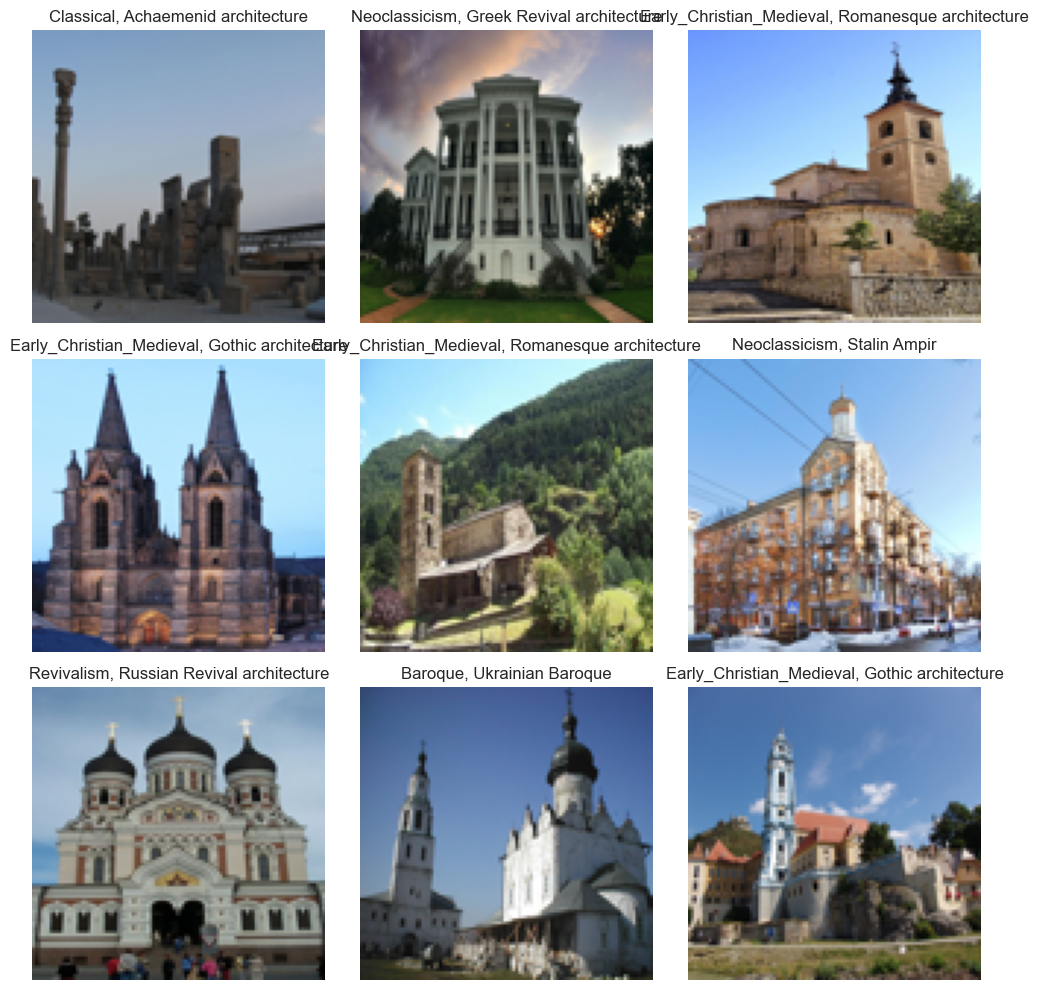

In [6]:
classes = [subfolder for subfolder in os.listdir(dataset_path) if
           os.path.isdir(os.path.join(dataset_path, subfolder))]
plt.figure(figsize=(10, 10))
data_to_show = data.sample(frac=1)[:9]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    img = Image.open(data_to_show.iloc[i, 0])  
    img_resized = img.resize((100, 100))
    plt.imshow(img_resized)
    plt.title(data_to_show.iloc[i, 1])  
    plt.axis("off")
plt.tight_layout()
plt.show()

# Data Split

In [7]:
train_dataset, validation_dataset = train_test_split(data,
                                               stratify=data['label'],
                                               test_size=0.2,
                                               random_state=42)
print(f"Train : Validation {train_dataset.shape} : {validation_dataset.shape}")

Train : Validation (13033, 2) : (3259, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


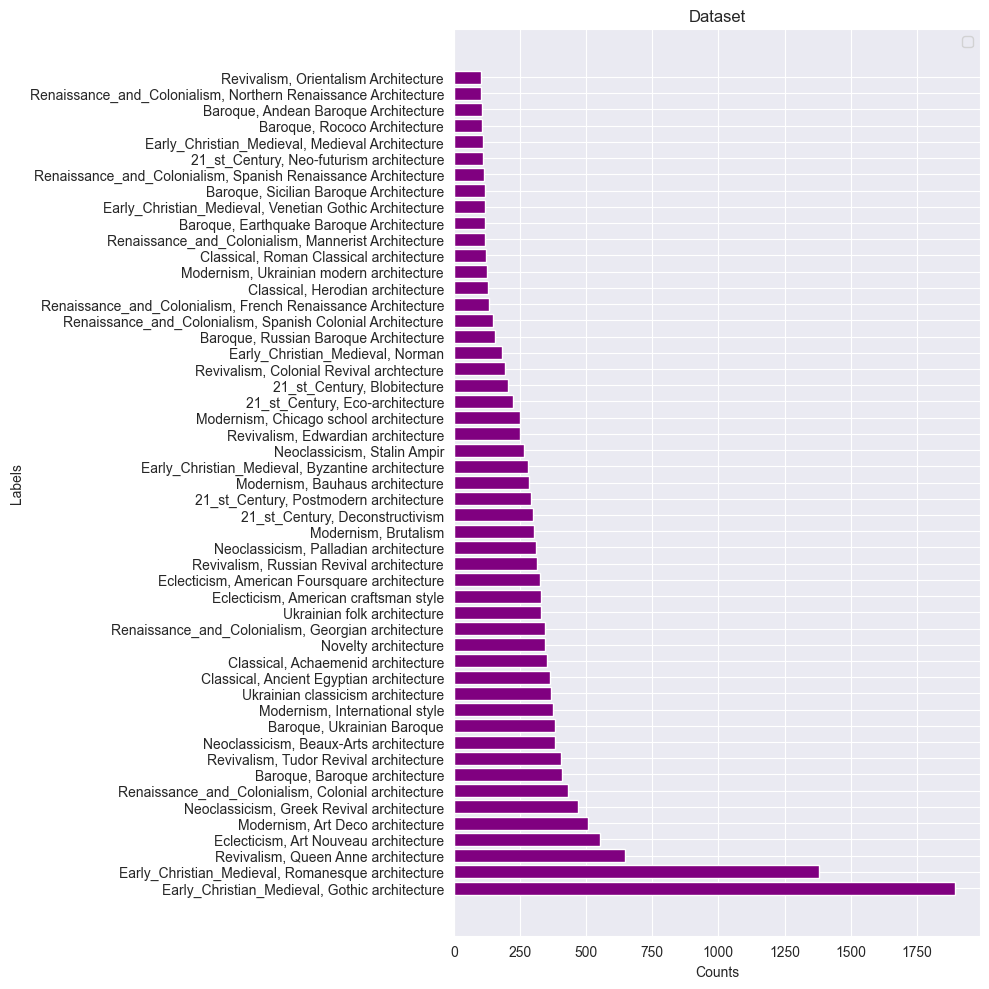

In [8]:
general_dataset_labels = data['label'].value_counts()
unique_labels = general_dataset_labels.index.tolist()
unique_labels.sort(key=lambda label: general_dataset_labels[label], reverse=True)

plt.figure(figsize=(10, 10))
plt.barh(range(len(unique_labels)), [general_dataset_labels.get(label, 0) for label in unique_labels], color='purple')
plt.title('Dataset')

plt.xlabel('Counts')
plt.ylabel('Labels')
plt.yticks(range(len(unique_labels)), unique_labels)
plt.tight_layout()
plt.show()


# Image Data Generators

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3

abs_file_names = []

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   shear_range=0.1,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.4,1.5],
                                   )

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,)

train_generator = train_datagen.flow_from_dataframe(
    train_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    num_workers=4,
)

validation_generator = test_datagen.flow_from_dataframe(
    validation_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    num_workers=4,
)

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning:

Found 1 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.



Found 13032 validated image filenames belonging to 51 classes.
Found 3259 validated image filenames belonging to 51 classes.


# Creating Model

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [11]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [12]:
def channel_attention(input_tensor, ratio=8):
    # Channel attention mechanism
    channels = input_tensor.shape[-1]
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
    shared_layer_one = tf.keras.layers.Dense(channels // ratio,
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channels,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    combined = tf.keras.layers.Add()([avg_pool, max_pool])
    output_tensor = tf.keras.layers.Activation('sigmoid')(combined)
    return tf.keras.layers.Multiply()([input_tensor, output_tensor])

In [33]:
def spatial_attention(input_tensor):
    # Spatial attention mechanism
    avg_pool =  tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_tensor)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_tensor)
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    conv = tf.keras.layers.Conv2D(filters=1,
                         kernel_size=(7, 7),
                         padding='same',
                         activation='sigmoid',
                         kernel_initializer='he_normal',
                         use_bias=False)(concat)
    output_tensor = tf.keras.layers.Multiply()([input_tensor, conv])
    return output_tensor

In [34]:
def cbam_block(input_tensor):
    # CBAM block combining channel and spatial attention
    channel = channel_attention(input_tensor)
    spatial = spatial_attention(input_tensor)
    output_tensor = tf.keras.layers.Concatenate()([channel, spatial])
    return output_tensor

In [43]:
def arc_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)

    inputs = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.EfficientNetV2B0(input_tensor=inputs,
                                                        include_top=False,
                                                        weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output  

    x = cbam_block(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(51, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model

In [44]:
arch_model = arc_model(IMG_SIZE)
print(arch_model.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 224, 224,  │          0 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 13,144,293 (50.14 MB)

 Trainable params: 7,224,981 (27.56 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None


In [46]:
arch_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=["accuracy"])
# Image.MAX_IMAGE_PIXELS = None

In [47]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=["accuracy"]
    )

In [48]:
unfreeze_model(arch_model)

In [49]:
res = arch_model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data = validation_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/100


C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2023 - loss: 0.7231

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



408/408 ━━━━━━━━━━━━━━━━━━━━ 939s 2s/step - accuracy: 0.2026 - loss: 0.7228 - val_accuracy: 0.4237 - val_loss: 0.4141 - learning_rate: 1.0000e-04
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.4360 - loss: 0.4127 - val_accuracy: 0.4781 - val_loss: 0.3520 - learning_rate: 1.0000e-04
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.4837 - loss: 0.3513 - val_accuracy: 0.5005 - val_loss: 0.3275 - learning_rate: 1.0000e-04
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.5063 - loss: 0.3224 - val_accuracy: 0.5226 - val_loss: 0.3055 - learning_rate: 1.0000e-04
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - accuracy: 0.5228 - loss: 0.3049 - val_accuracy: 0.5103 - val_loss: 0.2964 - learning_rate: 1.0000e-04
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 773s 2s/step - accuracy: 0.5338 - loss: 0.2906 - val_accuracy: 0.5361 - val_loss: 0.2878 - learning_rate: 1.0000e-04
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 771s 2s/step - accuracy

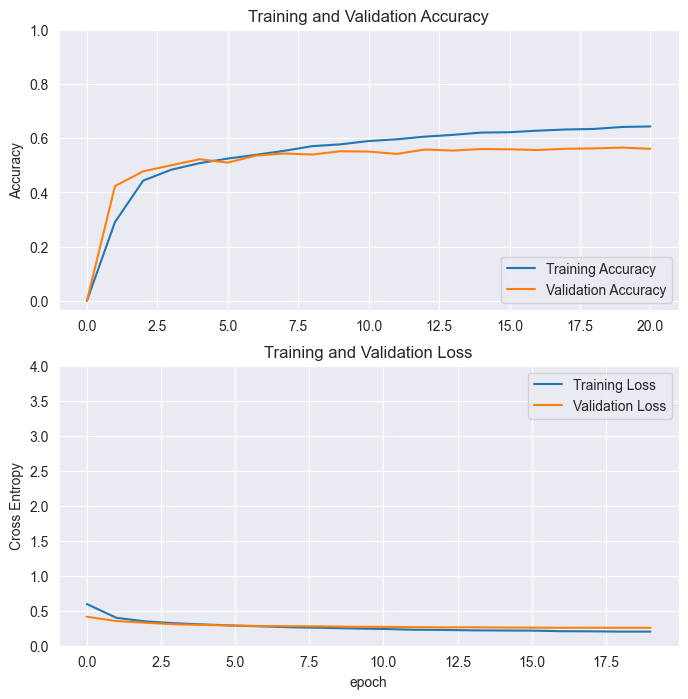

In [50]:
    # validation_steps=20)
acc = [0.] + res.history['accuracy']
val_acc = [0.] + res.history['val_accuracy']

loss = res.history['loss']
val_loss = res.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
test_generator = test_datagen.flow_from_directory(
    directory='D:/University/FinalDatasetSplited/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 1808 images belonging to 51 classes.


In [52]:
loss, accuracy = arch_model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=0)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Test Loss: 0.2614734172821045 Test Accuracy: 0.5746681690216064


In [53]:
loss, accuracy = arch_model.evaluate(train_generator, batch_size=BATCH_SIZE, verbose=0)
print('Train Loss:', loss, 'Train Accuracy:', accuracy)

Train Loss: 0.18634207546710968 Train Accuracy: 0.6693523526191711


In [54]:
loss, accuracy = arch_model.evaluate(validation_generator, batch_size=BATCH_SIZE, verbose=0)
print('Validation Loss:', loss, 'Validation Accuracy:', accuracy)

Validation Loss: 0.25597965717315674 Validation Accuracy: 0.5612151026725769


In [55]:
prediction = arch_model.predict(test_generator, batch_size=BATCH_SIZE, verbose=0)
pr = np.argmax(prediction, axis=1)
print(classification_report(test_generator.labels, pr, target_names=unique_labels))

                                                                precision    recall  f1-score   support

                 Early_Christian_Medieval, Gothic architecture       0.68      0.74      0.71        23
             Early_Christian_Medieval, Romanesque architecture       0.70      0.62      0.66        34
                           Revivalism, Queen Anne architecture       0.88      0.56      0.68        25
                         Eclecticism, Art Nouveau architecture       0.60      0.27      0.38        11
                              Modernism, Art Deco architecture       0.61      0.59      0.60        32
                     Neoclassicism, Greek Revival architecture       0.38      0.42      0.40        12
            Renaissance_and_Colonialism, Colonial architecture       0.53      0.59      0.56        46
                                 Baroque, Baroque architecture       0.25      0.08      0.12        13
                        Revivalism, Tudor Revival architecture 

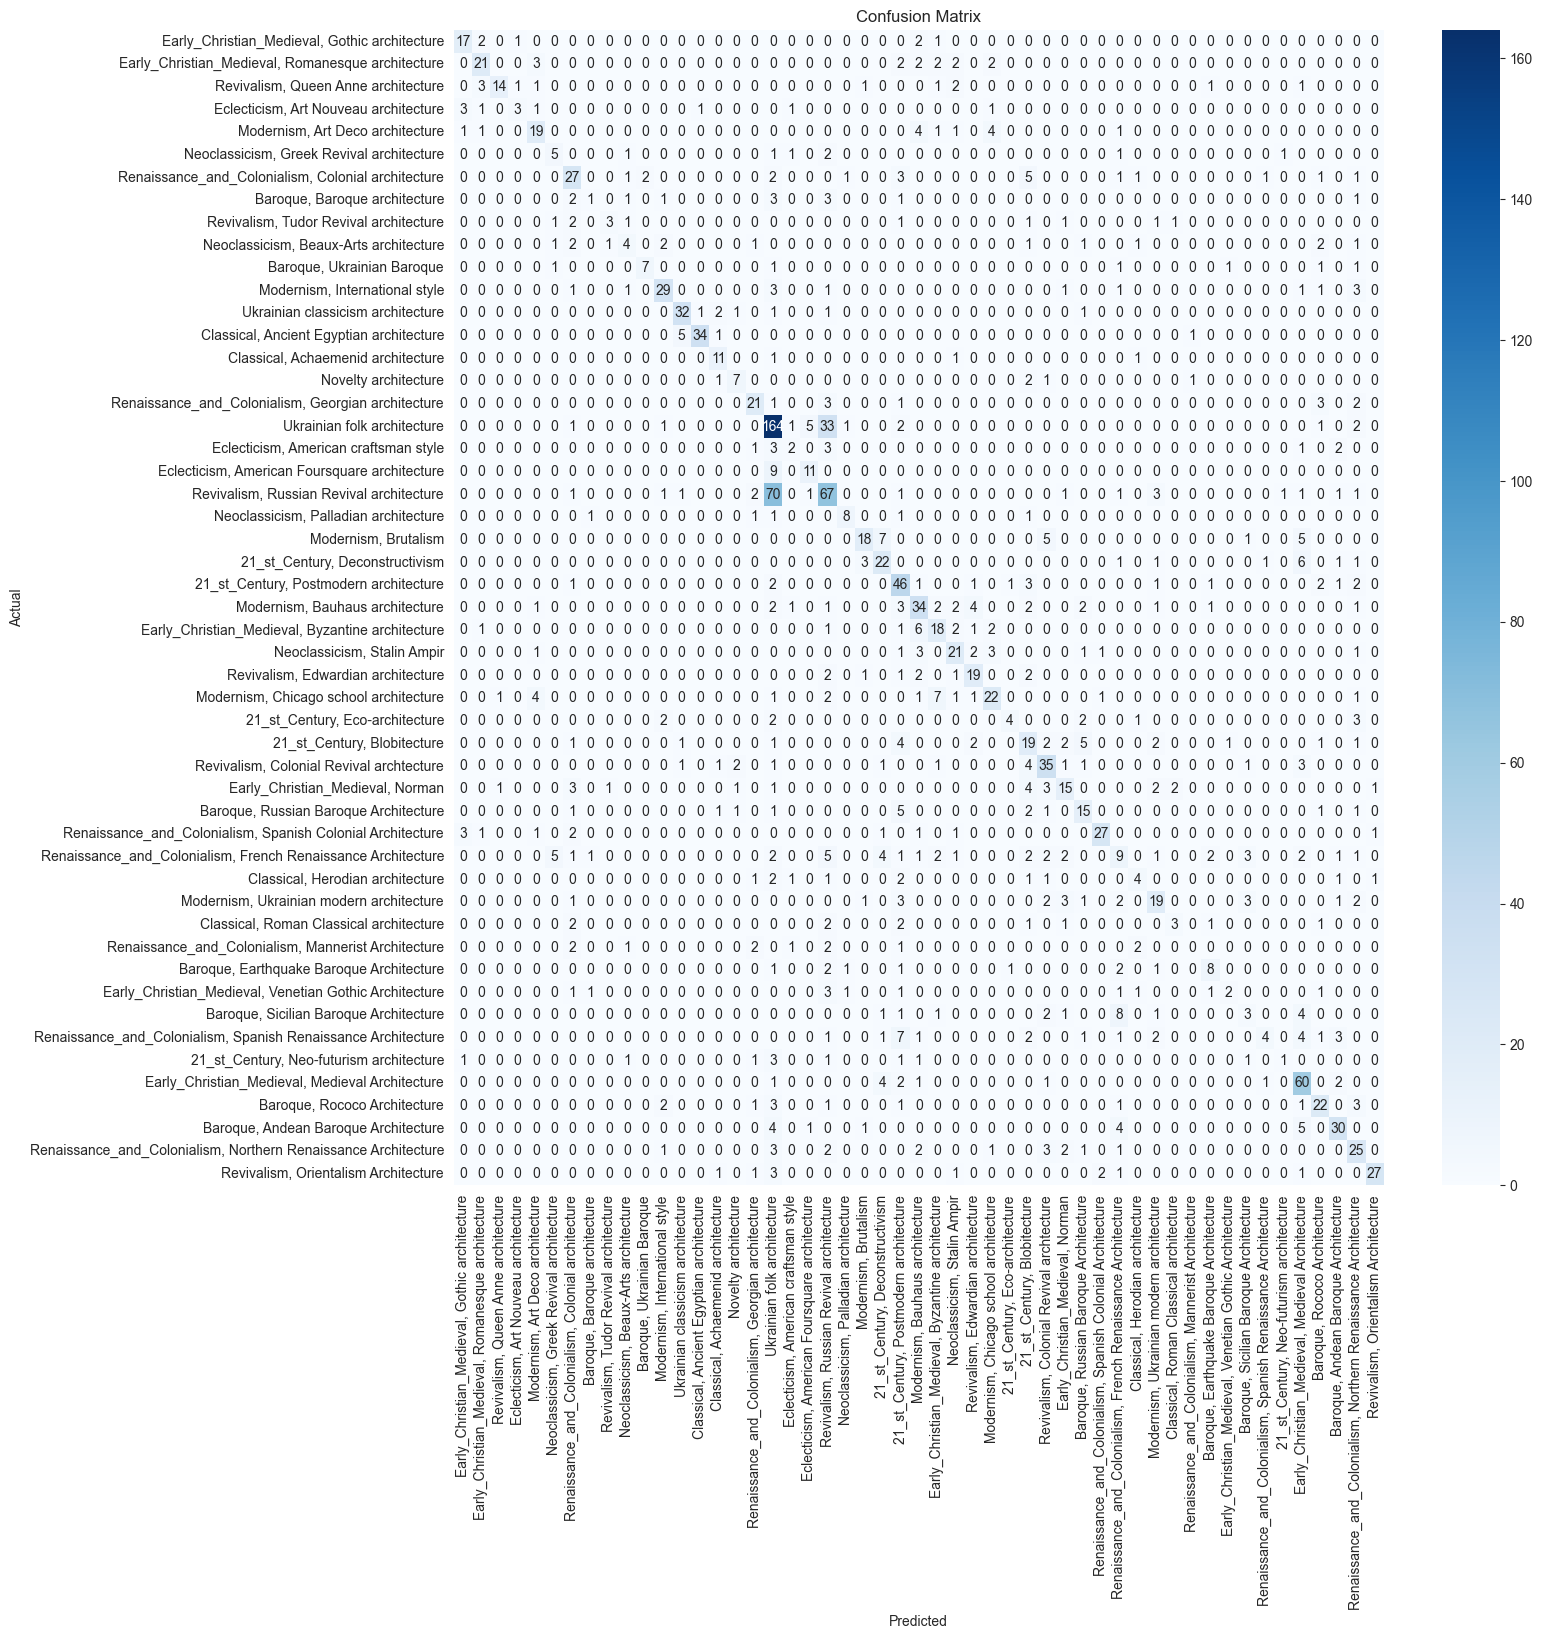

In [56]:
conf_matrix = confusion_matrix(test_generator.labels, pr)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [57]:
for epoch, history in enumerate(res.history['loss']):
    task.get_logger().report_scalar("training", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['accuracy']):
    task.get_logger().report_scalar("training", "accuracy", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_loss']):
    task.get_logger().report_scalar("validation", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_accuracy']):
    task.get_logger().report_scalar("validation", "accuracy", history, iteration=epoch)


In [58]:
arch_model.save("focal_cbam.h5")

TypeError: Task.upload_artifact() got multiple values for argument 'name'

In [59]:
task.upload_artifact(artifact_object="focal_cbam.h5", name="imbalanced")

True